# Final assignment - Task 2.
## Comparative Analysis of Epidemiological Models

**Author:** Pablo Rodríguez López
**Course**: Modelization and Simulation of Biosystem
**Masters**: Computational Biology
**University**: Polytechnic University of Madrid
**Date:** January 2026

---

## Task Description:

This task focuses on simple epidemiological models.
* Implement the SI and SIS models (see lecture slides on Moodle).
* Run simulations for different values of β (infection rate) and μ (recovery rate).
* Look for parameter values that produce interesting behavior (e.g., steady states, oscillations,
or unexpected outcomes).
* Compare your results with the SIR model discussed in class.
   * What are the main differences between SI, SIS, and SIR?
* Perform a sensitivity analysis using the SA Python package introduced during class.





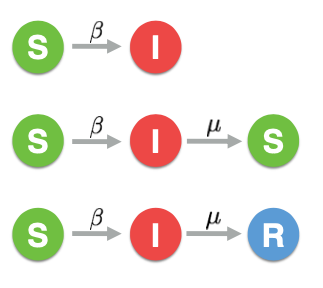

## Notebook objectives

This notebook implements and analyzes two **simple compartmental epidemic models** (SI and SIS) using the same numerical/sensitivity-analysis strategy as in the course notebooks:

- Numerical integration with `scipy.integrate.solve_ivp` (method `LSODA`).
- Visualization with `matplotlib`.
- Global sensitivity analysis with **SALib** (Saltelli sampling + Sobol indices).

In addition to simulations and sensitivity analysis, a simple **bifurcation-style analysis** is included by scanning parameters and extracting long-time equilibria.

> Notes:
> - Time unit is measured in days
> - The state variables $S(t), I(t)$ are counts (not fractions)


## Imports and utilities

The code below mirrors the course strategy: `numpy`, `matplotlib`, `solve_ivp`, plus SALib for sensitivity analysis.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Sensitivity analysis
print(f"\nInstalling SALib package for sensitivity analysis\n")
!pip install SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
print(f"\nSALib successfully installed\n")

plt.rcParams['figure.dpi'] = 120

# Print python and package versions
import sys
print("="*70)
print("SOFTWARE VERSIONS")
print("="*70)
print(f"\nPython version: {sys.version}")
print(f"numpy version: {np.__version__}")
import matplotlib
print(f"matplotlib version: {matplotlib.__version__}")
import scipy
print(f"scipy version: {scipy.__version__}")
print("="*70)




Installing SALib package for sensitivity analysis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 24.1 MB/s eta 0:00:00

SALib successfully installed

SOFTWARE VERSIONS

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
numpy version: 2.0.2
matplotlib version: 3.10.0
scipy version: 1.16.3


In [2]:
# Set visualization style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

### Helper functions

In [3]:
def solve_model(rhs, t_span, y0, args=(), t_eval=None, atol=1e-8, rtol=1e-8):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 400)
    sol = solve_ivp(
        rhs,
        (t_span[0], t_span[1]),
        y0,
        args=args,
        t_eval=t_eval,
        method='LSODA',
        atol=atol,
        rtol=rtol
    )
    return sol


def plot_time_series(t, series_dict, title=None, ylabel='Individuals'):
    fig, ax = plt.subplots(figsize=(6.5, 2.6))
    for label, y in series_dict.items():
        ax.plot(t, y, label=label)
    ax.set_xlabel('Time')
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)
    ax.legend()
    plt.show()


def plot_multi_runs(t, runs, title=None):
    fig, ax = plt.subplots(figsize=(6.8, 2.8))
    for r in runs:
        ax.plot(t, r['I'], label=r['label'])
    ax.set_xlabel('Time')
    ax.set_ylabel('Infected I(t)')
    if title:
        ax.set_title(title)
    ax.legend(fontsize=8)
    plt.show()


## 1. Comparing Dynamical Behavior Across Different Parameter Values

### 1) SI model

**Model equations**

$$
\begin{align*}
\frac{dS}{dt} &= -\beta S I\\\\
\frac{dI}{dt} &= \beta S I\\\\
\end{align*}
$$

Key properties:
- Total population \(N = S + I\) is conserved.
- There is **no recovery**.


In [4]:
def si_rhs(t, y, beta):
    S, I = y
    dSdt = -beta * S * I
    dIdt = beta * S * I
    return [dSdt, dIdt]


#### Simulation for different $\beta$ values

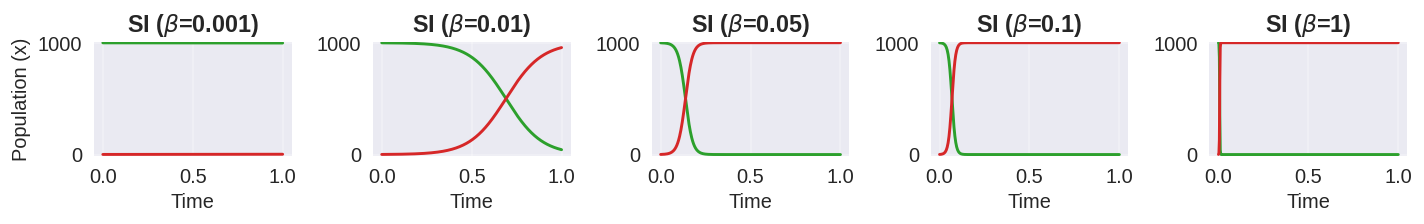

In [5]:
# Compare time series for different r values
beta_values = [0.001, 0.01, 0.05, 0.1, 1]
t = np.linspace(0, 1, 400)
N=1000
I0 = 1
S0 = N - I0

fig, axes = plt.subplots(1,len(beta_values), figsize=(2.4*len(beta_values),2))

for idx, beta in enumerate(beta_values):
    # Standard Logistic
    sol = solve_model(si_rhs, (t[0], t[-1]), [S0, I0], args=(beta,), t_eval=t)
    S, I = sol.y
    axes[idx].plot(t,S, label='S(t)',color='tab:green')
    axes[idx].plot(t,I, label='I(t)',color='tab:red')

    axes[idx].set_title(r'SI ($\beta$='+f'{beta})', fontsize=14, fontweight='bold')
    if idx == 0:
        axes[idx].set_ylabel('Population (x)', fontsize=12)
    axes[idx].set_xlabel('Time', fontsize=12)
    axes[idx].tick_params(axis='both', labelsize=12)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(-N*0.01, N*1.01)

plt.tight_layout()
plt.show()

### 2) SIS and SIR models

**SIS model**

**Model equations**

$$
\begin{align*}
\frac{dS}{dt} &= -\beta S I + \mu I\\\\
\frac{dI}{dt} &= \beta S I -  \mu I\\\\
\end{align*}
$$




In [6]:
def sis_rhs(t, y, beta, mu):
    S, I = y
    dSdt = -beta * S * I + mu * I
    dIdt = beta * S * I - mu * I
    return [dSdt, dIdt]


**SIR model**

**model equations**

$$
\begin{align*}
\frac{dS}{dt} &= -\beta S I \\\\
\frac{dI}{dt} &= \beta S I - \mu I \\\\
\frac{dR}{dt} &= \mu I
\end{align*}
$$

In [7]:
def sir_rhs(t, y, beta, mu):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - mu * I
    dRdt = mu * I
    return [dSdt, dIdt, dRdt]


### Simulation of SIS models for several $\beta$ and $\mu$ values



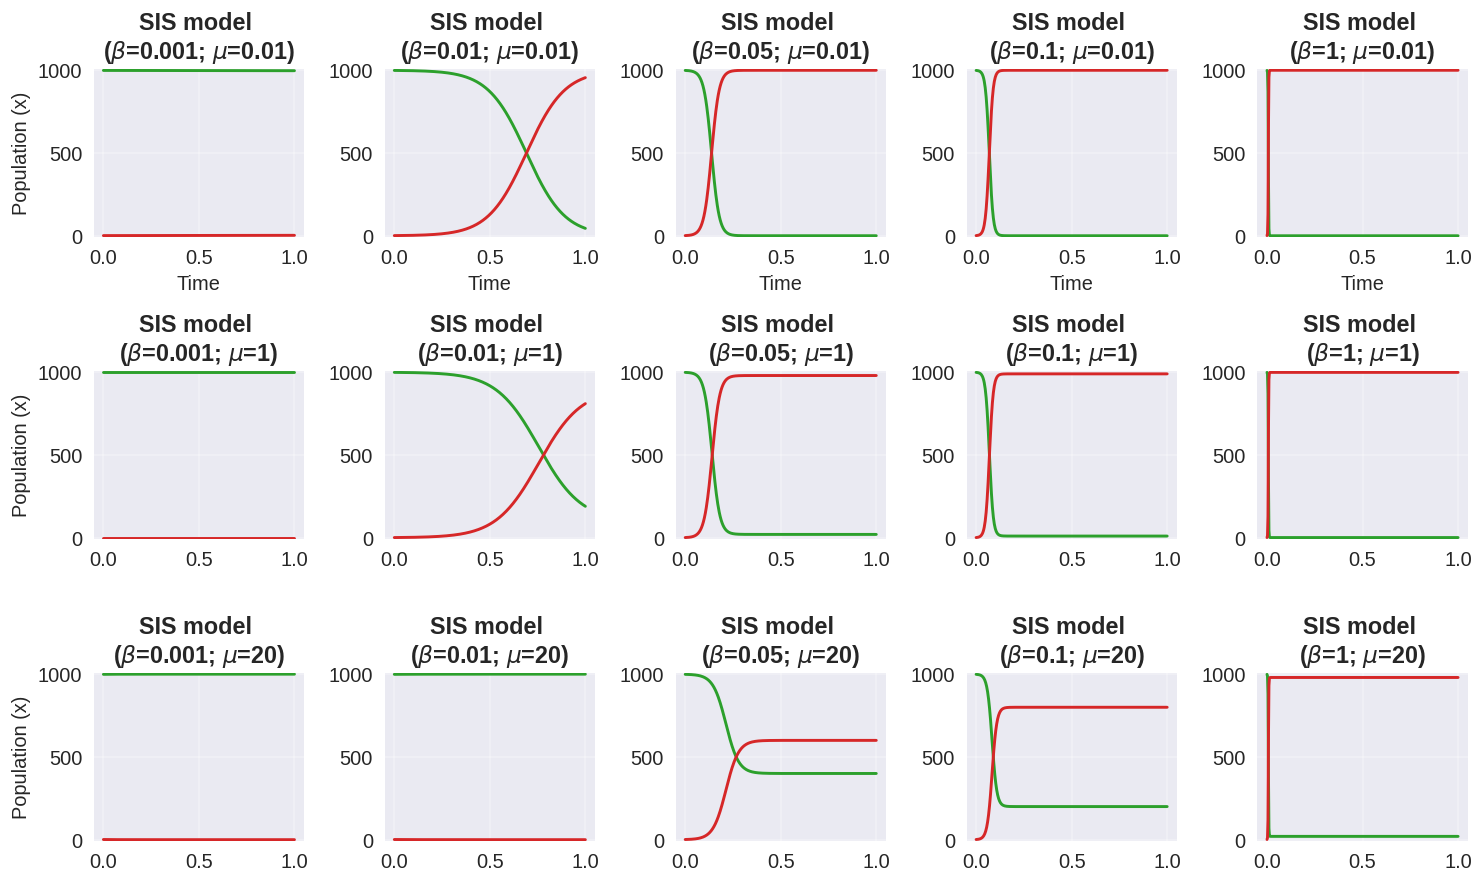

In [8]:
# Compare time series for different r values
beta_values = [0.001, 0.01, 0.05, 0.1, 1]
mu_values = [0.01, 1, 20]
t = np.linspace(0, 1, 400)
N=1000
I0 = 1
S0 = N - I0

fig, axes = plt.subplots(len(mu_values),len(beta_values), figsize=(2.5*len(beta_values),2.5*len(mu_values)))

for idx1, beta in enumerate(beta_values):
  for idx2, mu in enumerate(mu_values):
      # Standard Logistic
      sol = solve_model(sis_rhs, (t[0], t[-1]), [S0, I0], args=(beta,mu), t_eval=t)
      S, I = sol.y
      axes[idx2, idx1].plot(t,S, label='S(t)',color='tab:green')
      axes[idx2, idx1].plot(t,I, label='I(t)',color='tab:red')

      axes[idx2, idx1].set_title(f'SIS model \n'+r'($\beta$='+f'{beta}'+r'; $\mu$='+f'{mu})', fontsize=14, fontweight='bold')
      if idx1 == 0:
          axes[idx2, idx1].set_ylabel('Population (x)', fontsize=12)
      if idx2 == 0:
          axes[idx2, idx1].set_xlabel('Time', fontsize=12)
      axes[idx2, idx1].tick_params(axis='both', labelsize=12)
      axes[idx2, idx1].grid(True, alpha=0.3)
      axes[idx2, idx1].set_ylim(-N*0.01, N*1.01)

plt.tight_layout()
plt.show()

### Simulation of both SIS and SIR models for different $\beta$ and $\mu$ values

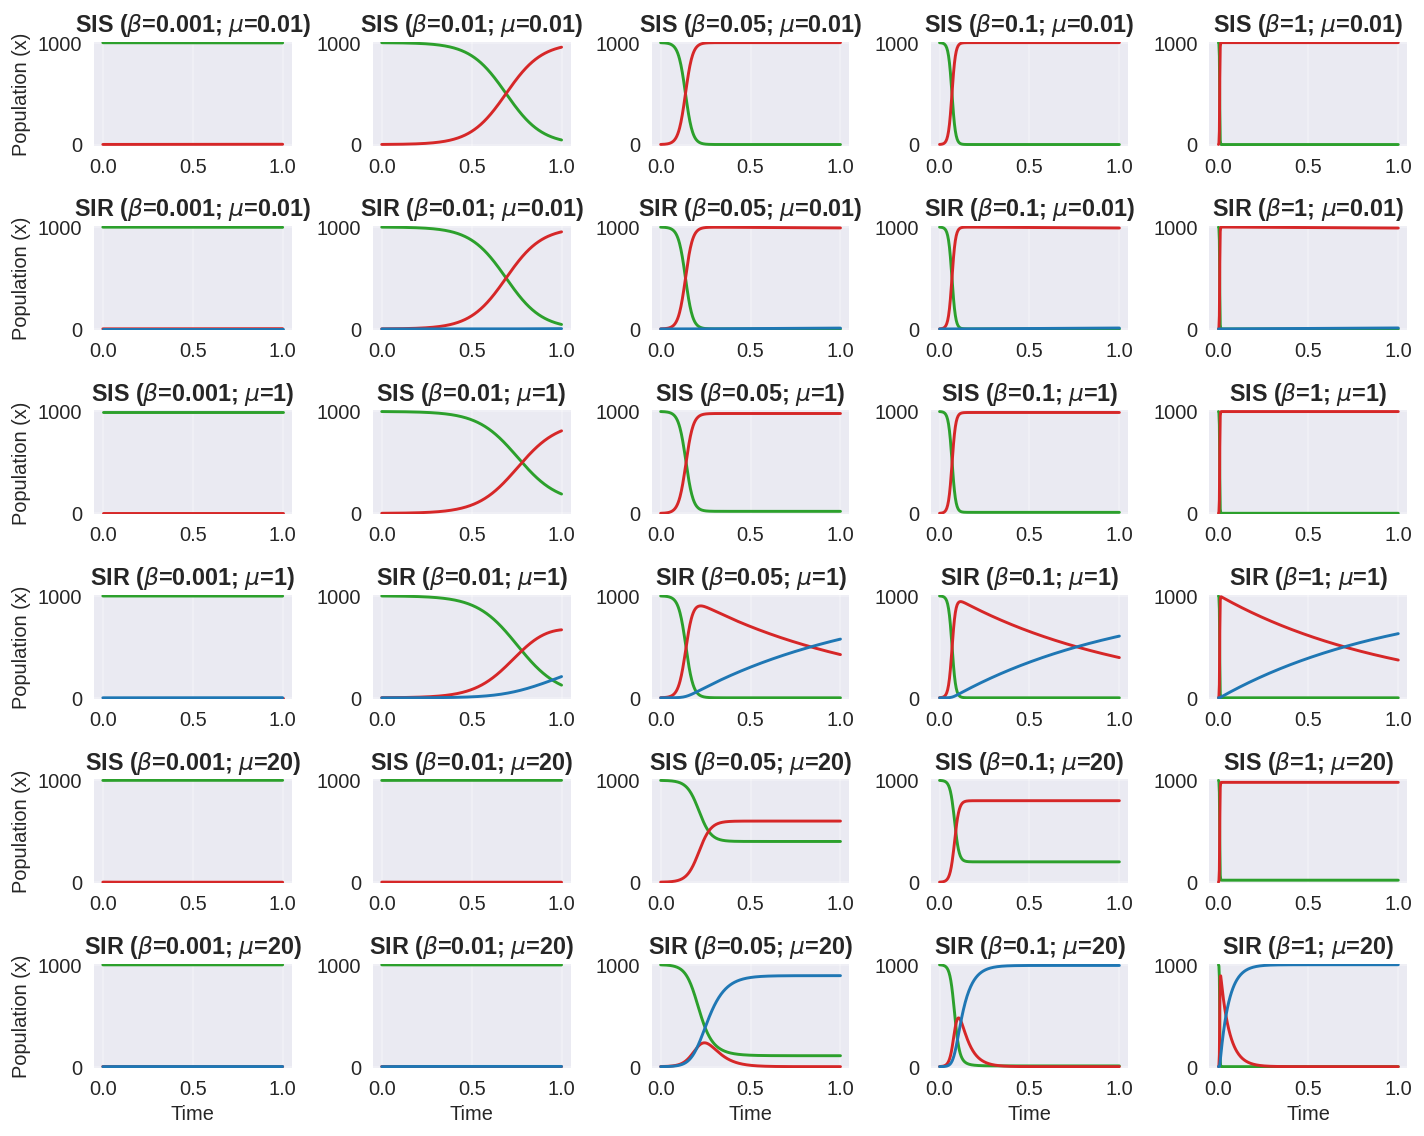

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- Parameters ---
beta_values = [0.001, 0.01, 0.05, 0.1, 1]
mu_values = [0.01, 1, 20]
t = np.linspace(0, 1, 400)
N = 1000
I0 = 1
S0 = N - I0
R0_sir = 0  # Initial recovered for SIR

# --- Figure setup ---
# We need 2 rows for each mu value (one for SIS, one for SIR)
n_rows = 2 * len(mu_values)
n_cols = len(beta_values)
fig_height = 1.6 * n_rows
fig_width = 2.4 * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

# Ensure axes is 2D array even if there is only 1 mu or 1 beta
if n_rows == 1: axes = np.array([axes])
if n_cols == 1: axes = axes.reshape(-1, 1)

# --- Loop ---
for idx_mu, mu in enumerate(mu_values):
    # Determine row indices for this mu
    row_sis = 2 * idx_mu      # Even rows: SIS
    row_sir = 2 * idx_mu + 1  # Odd rows: SIR

    for idx_beta, beta in enumerate(beta_values):

        # --- 1. SIS Simulation ---
        ax_sis = axes[row_sis, idx_beta]
        sol_sis = solve_model(sis_rhs, (t[0], t[-1]), [S0, I0], args=(beta, mu), t_eval=t)
        S_sis, I_sis = sol_sis.y

        ax_sis.plot(t, S_sis, label='S(t)', color='tab:green')
        ax_sis.plot(t, I_sis, label='I(t)', color='tab:red')

        # Styling SIS
        ax_sis.set_title(r'SIS '+r'($\beta$='+f'{beta}'+r'; $\mu$='+f'{mu})', fontsize=14, fontweight='bold')
        ax_sis.grid(True, alpha=0.3)
        ax_sis.set_ylim(-N*0.01, N*1.01)
        ax_sis.tick_params(axis='both', labelsize=12)
        # Only set ylabel on the very first column
        if idx_beta == 0:
          ax_sis.set_ylabel('Population (x)', fontsize=12)

        # --- 2. SIR Simulation ---
        ax_sir = axes[row_sir, idx_beta]
        sol_sir = solve_model(sir_rhs, (t[0], t[-1]), [S0, I0, R0_sir], args=(beta, mu), t_eval=t)
        S_sir, I_sir, R_sir = sol_sir.y

        ax_sir.plot(t, S_sir, label='S(t)', color='tab:green')
        ax_sir.plot(t, I_sir, label='I(t)', color='tab:red')
        ax_sir.plot(t, R_sir, label='R(t)', color='tab:blue') # Added R curve

        # Styling SIR
        ax_sir.set_title(r'SIR '+r'($\beta$='+f'{beta}'+r'; $\mu$='+f'{mu})', fontsize=14, fontweight='bold')
        ax_sir.grid(True, alpha=0.3)
        ax_sir.set_ylim(-N*0.01, N*1.01)
        ax_sir.tick_params(axis='both', labelsize=12)
        # Only set ylabel on the very first column
        if idx_beta == 0:
          ax_sir.set_ylabel('Population (x)', fontsize=12)

        # Only set xlabel on the very last row
        if row_sir == n_rows - 1:
            ax_sir.set_xlabel('Time', fontsize=12)

plt.tight_layout()
plt.show()


Comparing the SIR outocmes based on the I0 value:

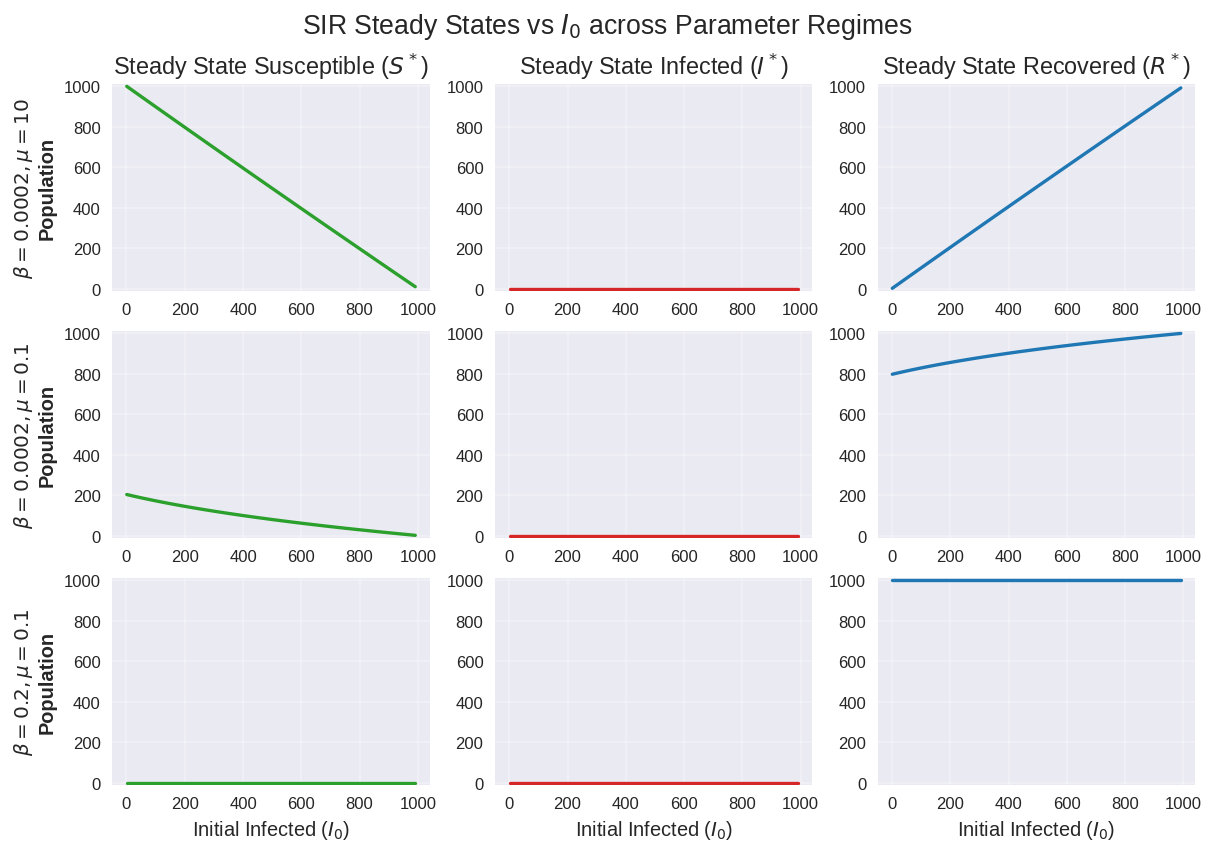

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- Model & Solver ---
def sir_rhs(t, y, beta, mu):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - mu * I
    dRdt = mu * I
    return [dSdt, dIdt, dRdt]

def solve_model(rhs, t_span, y0, args=(), t_eval=None, method='LSODA', rtol=1e-6, atol=1e-8):
    return solve_ivp(rhs, t_span, y0, args=args, t_eval=t_eval, method=method, rtol=rtol, atol=atol)

# --- Configuration ---
N = 1000
t_end = 1000
I0_values = np.arange(1, 1000, 10)

# Scenarios: (beta, mu) tuples
scenarios = [
    (2e-4, 10),   # Row 1
    (2e-4, 0.1),  # Row 2
    (2e-1, 0.1)   # Row 3
]

# --- Plot Setup ---
fig, axes = plt.subplots(3, 3, figsize=(10, 7), constrained_layout=True)

# Loop over scenarios (Rows)
for i, (beta, mu) in enumerate(scenarios):
    S_star, I_star, R_star = [], [], []

    # Run simulations for this scenario
    for I0 in I0_values:
        S0 = N - I0
        y0 = [S0, I0, 0] # R0=0
        sol = solve_model(sir_rhs, (0, t_end), y0, args=(beta, mu))
        S_star.append(sol.y[0][-1])
        I_star.append(sol.y[1][-1])
        R_star.append(sol.y[2][-1])

    # --- Plotting Columns ---

    # Col 0: S*
    ax_s = axes[i, 0]
    ax_s.plot(I0_values, S_star, color='tab:green', lw=2)
    ax_s.set_ylabel(f"$\\beta={beta}, \\mu={mu}$\nPopulation", fontsize=12, fontweight='bold')
    if i == 0: ax_s.set_title("Steady State Susceptible ($S^*$)", fontsize=14)

    # Col 1: I*
    ax_i = axes[i, 1]
    ax_i.plot(I0_values, I_star, color='tab:red', lw=2)
    if i == 0: ax_i.set_title("Steady State Infected ($I^*$)", fontsize=14)

    # Col 2: R*
    ax_r = axes[i, 2]
    ax_r.plot(I0_values, R_star, color='tab:blue', lw=2)
    if i == 0: ax_r.set_title("Steady State Recovered ($R^*$)", fontsize=14)

    # Styling for all axes in this row
    for ax in [ax_s, ax_i, ax_r]:
        ax.set_ylim(-N*0.01, N*1.01)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', labelsize=10)
        # Only set xlabel on bottom row
        if i == 2:
            ax.set_xlabel("Initial Infected ($I_0$)", fontsize=12)

plt.suptitle("SIR Steady States vs $I_0$ across Parameter Regimes", fontsize=16)
plt.show()


## 2. Stability analysis

In [58]:
def SIS_bifurcation_search(beta_grid, mu_grid, N=1000, I0=1, t_total=400, timestep=100):
    """
    Simulates the SIS model for a grid of parameters and returns steady-state metrics.

    Parameters:
    - beta_grid: 1D array of beta values
    - mu_grid: 1D array of mu values
    - N, I0, t_total, timestep: Model constants

    Returns:
    - results: Dictionary containing 2D arrays for S_mean, I_mean, S_amp, I_amp
    """
    # Ensure inputs are arrays
    betas = np.asarray(beta_grid)
    mus = np.asarray(mu_grid)

    # Initialize output matrices
    shape = (len(mus), len(betas))
    S_mean = np.zeros(shape)
    I_mean = np.zeros(shape)
    S_amp = np.zeros(shape)
    I_amp = np.zeros(shape)

    # Define dense time evaluation to capture potential oscillations
    # We use a high resolution to ensure 'last 100 points' covers a meaningful window
    t_eval = np.linspace(0, t_total, timestep*t_total)

    S0 = N - I0
    y0 = [S0, I0]

    print(f"Starting simulation for {shape[0] * shape[1]} parameter combinations...")

    for i, mu in enumerate(mus):
        for j, beta in enumerate(betas):
            # 1. Simulate
            sol = solve_ivp(sis_rhs, (0, t_total), y0, args=(beta, mu),
                            t_eval=t_eval, method='LSODA', rtol=1e-6, atol=1e-8)

            S = sol.y[0]
            I = sol.y[1]

            # 2. Extract last 100 timepoints (Tail)
            # Robust check: ensure simulation didn't fail/return too few points
            if len(S) > 100:
                S_tail = S[-10*timestep:]
                I_tail = I[-10*timestep:]
            else:
                S_tail = S
                I_tail = I

            # 3. Compute Metrics
            # Mean
            S_mean[i, j] = np.mean(S_tail)
            I_mean[i, j] = np.mean(I_tail)

            # Oscillation Score (Amplitude: Max - Min)
            # If it's a stable steady state, this will be ~0 (floating point noise)
            # If it oscillates, this will be > 0
            S_amp[i, j] = np.max(S_tail) - np.min(S_tail)
            I_amp[i, j] = np.max(I_tail) - np.min(I_tail)

    return {
        "S_mean": S_mean,
        "I_mean": I_mean,
        "S_amp": S_amp,
        "I_amp": I_amp
    }

In [59]:
# --- 1. Define Grids (Robust Inputs) ---
# Using logspace covers orders of magnitude, good for finding boundaries
beta_vals = np.logspace(-4, 0, 100)  # e.g., 0.0001 to 1
mu_vals   = np.logspace(-3, 1, 100)   # e.g., 0.001 to 10.0

# --- 2. Run the Function ---
results = SIS_bifurcation_search(beta_vals, mu_vals, N=1000, t_total=1000)

Starting simulation for 10000 parameter combinations...


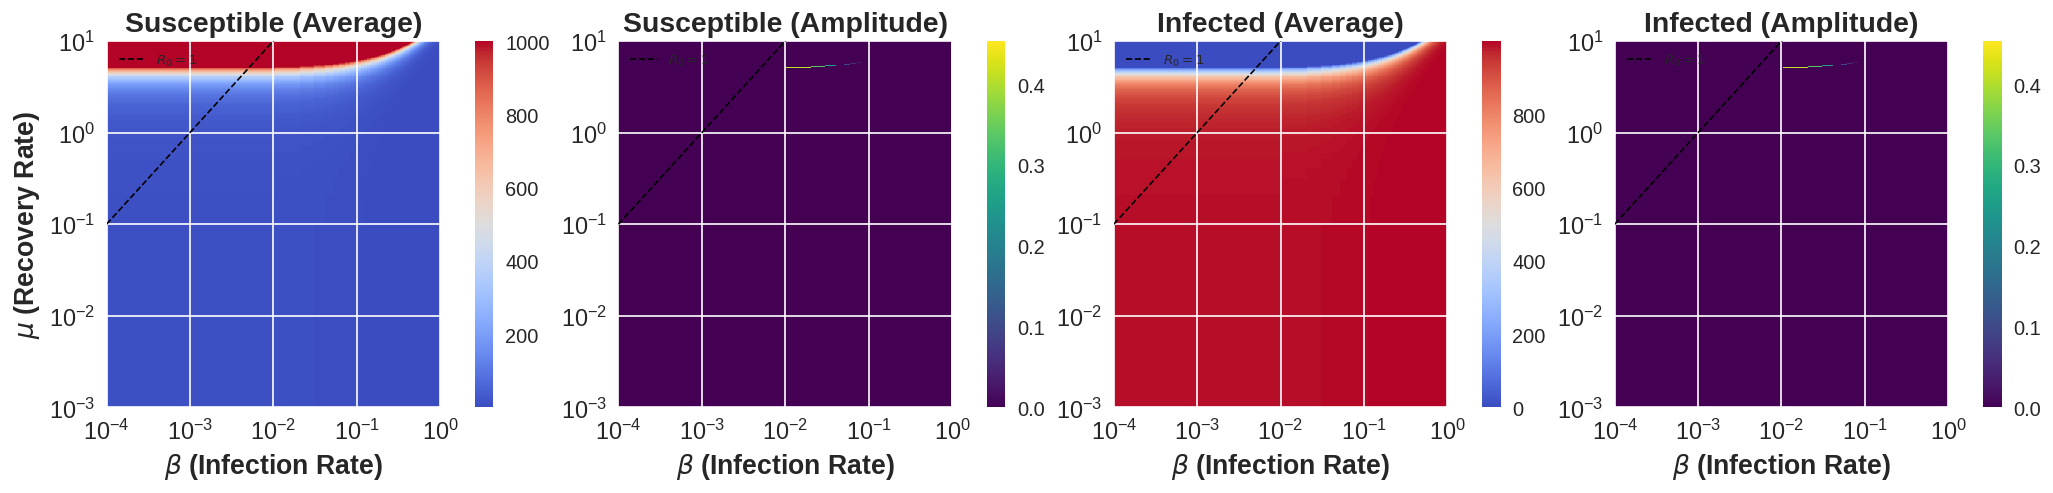

In [78]:
# --- 3. Plotting the 4 Subplots ---
fig, axes = plt.subplots(1, 4, figsize=(17, 4), constrained_layout=True)

# Data Mapping for easier looping
# Row 0: Means, Row 1: Amplitudes
# Col 0: Susceptible, Col 1: Infected
plots_config = [
    [
        {"data": results["S_mean"], "title": "Susceptible (Average)", "cmap": "coolwarm"},
        {"data": results["I_mean"], "title": "Infected (Average)", "cmap": "coolwarm"}
    ],
    [
        {"data": results["S_amp"],  "title": "Susceptible (Amplitude)", "cmap": "viridis"}, # Viridis highlights 0 better
        {"data": results["I_amp"],  "title": "Infected (Amplitude)", "cmap": "viridis"}
    ]
]

# Extent for imshow to map matrix indices to parameter values
extent = [beta_vals.min(), beta_vals.max(), mu_vals.min(), mu_vals.max()]

for row_idx in range(2):
    for col_idx in range(2):
        ax = axes[row_idx+ 2*col_idx]
        cfg = plots_config[row_idx][col_idx]

        # Create Heatmap
        # origin='lower' puts the first mu value at the bottom
        im = ax.imshow(cfg["data"], origin='lower', aspect='auto', extent=extent, cmap=cfg["cmap"])

        # Formatting
        ax.set_title(cfg["title"], fontsize=17, fontweight='bold')
        ax.set_xlabel(r'$\beta$ (Infection Rate)', fontsize=16, fontweight='bold')
        if row_idx == 0 and col_idx == 0:
          ax.set_ylabel(r'$\mu$ (Recovery Rate)', fontsize=16, fontweight='bold')
        ax.tick_params(axis='both', labelsize=14)


        # Set scales to log to match the input grid distribution
        ax.set_xscale('log')
        ax.set_yscale('log')

        # Set xlim and ylim according beta and mu values
        ax.set_xlim(extent[:2])
        ax.set_ylim(extent[2:])

        # Colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('')
        # size of the colorbar numbers
        cbar.ax.tick_params(labelsize=12)

        # Optional: Overlay R0 = 1 line (where beta*N = mu)
        # This helps verify the boundary visually
        beta_line = np.logspace(np.log10(beta_vals.min()), np.log10(beta_vals.max()), 100)
        mu_line = beta_line * 1000 # N=1000
        ax.plot(beta_line, mu_line, 'k--', linewidth=1, label=r'$R_0=1$')
        ax.legend(loc='upper left', fontsize=8)

#plt.suptitle("SIS Bifurcation Analysis: Mean vs Amplitud at the Steady State", fontsize=24)
plt.show()


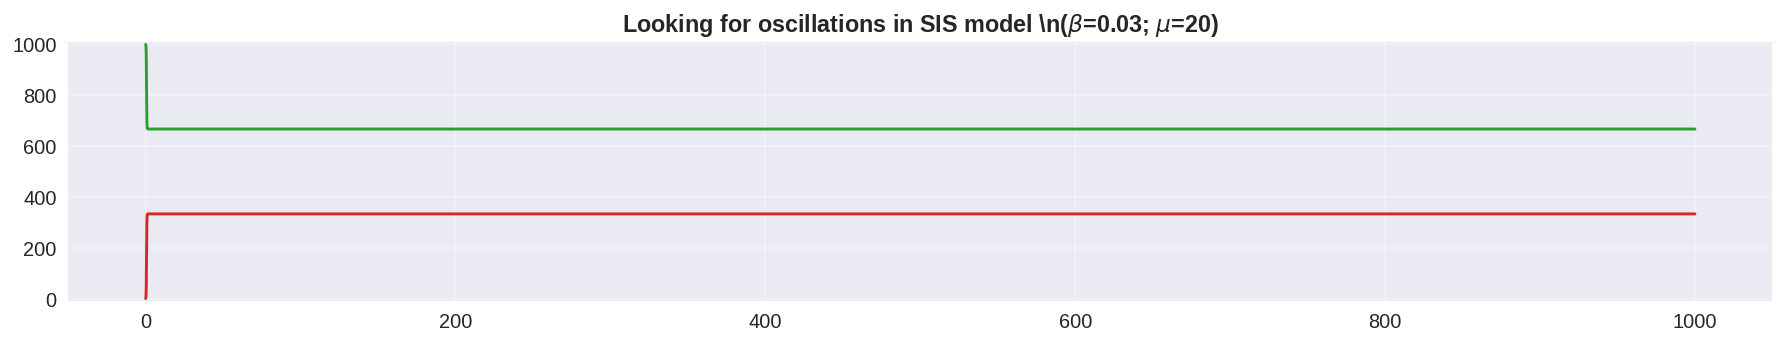

In [76]:
beta = 0.03
mu = 20
t = np.linspace(0, 1000, 400*1000)
N=1000
I0 = 1
S0 = N - I0

fig = plt.figure(figsize=(15,3))

sol = solve_model(sis_rhs, (t[0], t[-1]), [S0, I0], args=(beta,mu), t_eval=t)
S, I = sol.y
plt.plot(t,S, label='S(t)',color='tab:green')
plt.plot(t,I, label='I(t)',color='tab:red')

plt.title(r'SIS model \n($\beta$='+f'{beta}'+r'; $\mu$='+f'{mu})', fontsize=14, fontweight='bold')
if idx1 == 0:
    plt.ylabel('Population (x)', fontsize=12)
if idx2 == 0:
    plt.xlabel('Time', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(-N*0.01, N*1.01)

plt.tight_layout()
plt.show()

## 3. Sensitivity analysis (SALib)

- **SI** output: time to reach 50% infected (T50).
- **SIS** output: endemic infected level (I*).


### SI sensitivity: T50

**Metric:** Time to reach 50% infection ($T_{50}$).  
**Parameters:** $\beta$ (Infection rate), $I_0$ (Initial infected).  
**Fix:** `t_end` increased to 200.  

In [111]:
# 1. Define Problem
problem_si = {
    'num_vars': 2,
    'names': ['beta', 'I0'],
    'bounds': [[5e-5, 5e-4], # beta varies from 5e-5 to 5e-4
              [1, 20]]      # I0 varies from 1 to 20
}

# 2. Define Output Function
def get_T50_si(beta, I0, N=1000, t_end=200): # t_end increased significantly
    S0 = N - I0
    t_eval = np.linspace(0, t_end, 50*t_end)
    sol = solve_model(si_rhs, (0, t_end), [S0, I0], args=(beta,), t_eval=t_eval)

    I = sol.y[1]
    target = 0.5 * N

    # Find first time I >= target
    idx = np.where(I >= target)[0]
    if len(idx) == 0:
        return t_end # Censored data if not reached
    return sol.t[idx[0]]

# 3. Generate Samples
N_sobol = 512
param_values_si = saltelli.sample(problem_si, N_sobol, calc_second_order=False)

# 4. Run Simulations
Y_si = np.zeros(param_values_si.shape[0])
for i, (beta_val, I0_val) in enumerate(param_values_si):
    Y_si[i] = get_T50_si(beta_val, I0_val)

# 5. Analyze
si_indices = sobol.analyze(problem_si, Y_si, calc_second_order=False, print_to_console=True)

/tmp/ipython-input-2742862808.py:26: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values_si = saltelli.sample(problem_si, N_sobol, calc_second_order=False)


            ST   ST_conf
beta  0.966591  0.084356
I0    0.063069  0.013648
            S1   S1_conf
beta  0.946686  0.130406
I0    0.040093  0.029304


### SIS sensitivity: endemic level I*

**Metric:** Endemic equilibrium level ($I^*$).  
**Parameters:** $\beta$, $\mu$.

In [112]:
# 1. Define Problem
problem_sis = {
    'num_vars': 2,
    'names': ['beta', 'mu'],
    'bounds': [[5e-5, 5e-4],  # beta varies from 5e-5 to 5e-4
                [0.01, 0.2]] # mu varies from 0.01 to 0.2
}

# 2. Define Output Function
def get_Istar_sis(beta, mu, N=1000, t_end=400):
    # Run long enough to settle
    t_eval = np.linspace(0, t_end, 50*t_end)
    sol = solve_model(sis_rhs, (0, t_end), [N-1, 1], args=(beta, mu), t_eval=t_eval)
    I = sol.y[1]
    # Mean of last 10%
    return I[int(0.9*len(I)):].mean()

# 3. Generate Samples
param_values_sis = saltelli.sample(problem_sis, N_sobol, calc_second_order=False)

# 4. Run Simulations
Y_sis = np.zeros(param_values_sis.shape[0])
for i, (beta_val, mu_val) in enumerate(param_values_sis):
    Y_sis[i] = get_Istar_sis(beta_val, mu_val)

# 5. Analyze
sis_indices = sobol.analyze(problem_sis, Y_sis, calc_second_order=False, print_to_console=True)

/tmp/ipython-input-3163450425.py:19: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values_sis = saltelli.sample(problem_sis, N_sobol, calc_second_order=False)


            ST   ST_conf
beta  0.577015  0.073257
mu    0.510926  0.082580
            S1   S1_conf
beta  0.497895  0.089371
mu    0.429147  0.084413


### SIR Sensitivity Analysis

**Metric:** Peak infection ($I_{max}$).  
**Parameters:** $\beta$, $\mu$ (Recovery rate).

In [113]:
# 1. Define Problem (Same ranges as SIS for comparison)
problem_sir = {
    'num_vars': 2,
    'names': ['beta', 'mu'],
    'bounds': [[5e-5, 5e-4], # beta varies from 5e-5 to 5e-4
              [0.01, 0.2]]   # mu varies from 0.01 to 0.2
}

# 2. Define Output Function
def get_peak_I_sir(beta, mu, N=1000, t_end=200):
    t_eval = np.linspace(0, t_end, 50*t_end)
    sol = solve_model(sir_rhs, (0, t_end), [N-1, 1, 0], args=(beta, mu), t_eval=t_eval)
    I = sol.y[1]
    return I.max()

# 3. Generate Samples
param_values_sir = saltelli.sample(problem_sir, N_sobol, calc_second_order=False)

# 4. Run Simulations
Y_sir = np.zeros(param_values_sir.shape[0])
for i, (beta_val, mu_val) in enumerate(param_values_sir):
    Y_sir[i] = get_peak_I_sir(beta_val, mu_val)

# 5. Analyze
sir_indices_imax = sobol.analyze(problem_sir, Y_sir, calc_second_order=False, print_to_console=True)


/tmp/ipython-input-3531562948.py:17: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values_sir = saltelli.sample(problem_sir, N_sobol, calc_second_order=False)


            ST   ST_conf
beta  0.373957  0.053418
mu    0.665916  0.075028
            S1   S1_conf
beta  0.329581  0.073238
mu    0.623636  0.088643


In [115]:
# 1. Define Problem (Same ranges as SIS for comparison)
problem_sir = {
    'num_vars': 2,
    'names': ['beta', 'mu'],
    'bounds': [[5e-5, 5e-4], # beta varies from 5e-5 to 5e-4
              [0.01, 0.2]]   # mu varies from 0.01 to 0.2
}

# 2. Define Output Function
def get_T50_sir(beta, mu, N=1000, t_end=200):
    t_eval = np.linspace(0, t_end, 50*t_end)
    sol = solve_model(sir_rhs, (0, t_end), [N-1, 1, 0], args=(beta,mu), t_eval=t_eval)

    I = sol.y[1]
    target = 0.5 * N

    # Find first time I >= target
    idx = np.where(I >= target)[0]
    if len(idx) == 0:
        return t_end # Censored data if not reached
    return sol.t[idx[0]]


# 3. Generate Samples
param_values_sir = saltelli.sample(problem_sir, N_sobol, calc_second_order=False)

# 4. Run Simulations
Y_sir = np.zeros(param_values_sir.shape[0])
for i, (beta_val, mu_val) in enumerate(param_values_sir):
    Y_sir[i] = get_T50_sir(beta_val, mu_val)

# 5. Analyze
sir_indices_T50 = sobol.analyze(problem_sir, Y_sir, calc_second_order=False, print_to_console=True)


/tmp/ipython-input-3261860180.py:25: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values_sir = saltelli.sample(problem_sir, N_sobol, calc_second_order=False)


            ST   ST_conf
beta  0.481160  0.108576
mu    0.844809  0.117299
            S1   S1_conf
beta  0.103003  0.098223
mu    0.508385  0.125828


### Model Comparison Figure
We compare the **First-order (S1)** and **Total-order (ST)** sensitivity indices for the key parameters in each model.



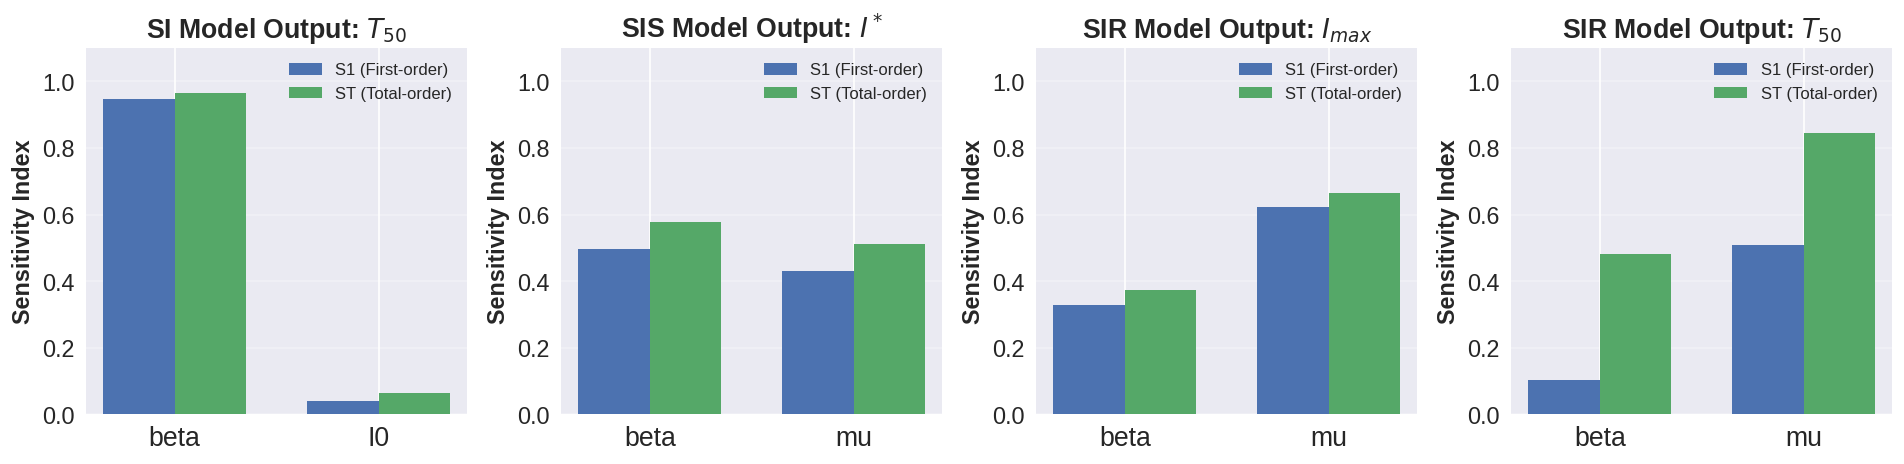

In [116]:
def plot_sobol(ax, indices, problem, title):
    labels = problem['names']
    S1 = indices['S1']
    ST = indices['ST']
    x = np.arange(len(labels))
    width = 0.35

    rects1 = ax.bar(x - width/2, S1, width, label='S1 (First-order)')
    rects2 = ax.bar(x + width/2, ST, width, label='ST (Total-order)')

    ax.set_ylabel('Sensitivity Index', fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=14)
    ax.legend()
    ax.set_ylim(0, 1.1) # Indices are usually 0-1
    ax.grid(axis='y', alpha=0.3)

# Create 3-subplot figure
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

plot_sobol(axes[0], si_indices, problem_si, 'SI Model Output: $T_{50}$')
plot_sobol(axes[1], sis_indices, problem_sis, 'SIS Model Output: $I^*$')
plot_sobol(axes[2], sir_indices_imax, problem_sir, 'SIR Model Output: $I_{max}$')
plot_sobol(axes[3], sir_indices_T50, problem_sir, 'SIR Model Output: $T_{50}$')


plt.tight_layout()
plt.show()